# Homework 4

- [homework](https://github.com/alexkolo/ml-zoomcamp-2024/blob/main/cohorts/2024/04-evaluation/homework.md)
- [submit here](https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw04)
    - Due date: 22 October 2024 01:00 (local time)
    - [link to notebook](https://github.com/alexkolo/ml-zoomcamp-2024/blob/main/cohorts/2024/04-evaluation/hw04_my_answers.ipynb)

## Dataset

In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip
```

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not. 

### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [1]:
import pandas as pd

df: pd.DataFrame = pd.read_csv(filepath_or_buffer="../03-classification/bank-full.csv", sep=";")
cols: list[str] = [
    "age",
    "job",
    "marital",
    "education",
    "balance",
    "housing",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
    "y",
]
df = df[cols]

In [2]:
df["y"] = df["y"].map(arg={"yes": 1, "no": 0})

In [3]:
target = "y"

In [4]:
from sklearn.model_selection import train_test_split

seed = 1
f_text = 0.2
f_val = 0.2

df_full_train, df_test = train_test_split(df.drop(columns="y"), test_size=f_text, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=f_val, random_state=seed)


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `y` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

#### Answer (not sure if correct)

`duration`

see slack discussion: https://datatalks-club.slack.com/archives/C0288NJ5XSA/p1728902527746739

In [5]:
numerical: list[str] = df_train.select_dtypes(include="number").columns.to_list()

In [6]:
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

In [7]:
auc_dict: dict[str, float] = {}
for feature in numerical:
    X_train: np.ndarray = df_train[feature].to_numpy()
    target_train: np.ndarray = df[target][df_train.index].to_numpy()

    # i_sort = np.argsort(X_train)
    # auc_dict[feature] = auc(x=X_train[i_sort], y=y_train[i_sort])

    fpr, tpr, thresholds = roc_curve(y_true=target_train, y_score=X_train)
    auc_dict[feature] = auc(x=fpr, y=tpr)

In [8]:
pd.Series(auc_dict).sort_values(ascending=False).head(n=1)

duration    0.814292
dtype: float64

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

#### Answer

`0.89`

In [9]:
numerical: list[str] = df_train.select_dtypes(include="number").columns.to_list()
categorical: list[str] = df_train.select_dtypes(exclude="number").columns.to_list()
features: list[str] = categorical + numerical

In [10]:
from sklearn.feature_extraction import DictVectorizer

In [11]:
dv = DictVectorizer(sparse=False)
train_dict: dict = df_train[features].to_dict(orient="records")
X_train: np.ndarray = dv.fit_transform(X=train_dict)
target_train: np.ndarray = df[target][df_train.index].to_numpy()
val_dict: dict = df_val[features].to_dict(orient="records")
X_val: np.ndarray = dv.transform(X=val_dict)
y_val: np.ndarray = df[target][df_val.index].to_numpy()

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)

In [13]:
model.fit(X=X_train, y=target_train)
y_pred: "pd.Series[float]" = model.predict_proba(X=X_val)[:, 1]

In [14]:
fpr, tpr, thresholds = roc_curve(y_true=y_val, y_score=y_pred)
round(number=auc(x=fpr, y=tpr), ndigits=3)

np.float64(0.899)

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

#### Answer

`0.265`

In [15]:
scores: list[tuple[float, ...]] = []

actual_positive: np.ndarray = y_val == 1
actual_negative: np.ndarray = y_val == 0
thresholds = np.arange(0, 1, 0.01)

for t in thresholds:
    predict_positive: np.ndarray = y_pred >= t
    predict_negative: np.ndarray = y_pred < t

    tp: float = (predict_positive & actual_positive).sum()
    tn: float = (predict_negative & actual_negative).sum()

    fp: float = (predict_positive & actual_negative).sum()
    fn: float = (predict_negative & actual_positive).sum()

    # Precision (positive predictive value): fraction of relevant instances among the retrieved instances
    p: float = tp / (tp + fp)

    # recall (aka sensitivity): fraction of relevant instances that were retrieved
    r: float = tp / (tp + fn)

    # f1-score
    f1: float = 2 * p * r / (p + r)

    scores.append((t, tp, fp, fn, tn, p, r, f1))

In [16]:
columns: list[str] = ["threshold", "tp", "fp", "fn", "tn", "precision", "recall", "f1-score"]
df_scores = pd.DataFrame(data=scores, columns=columns)

In [17]:
import matplotlib.pyplot as plt

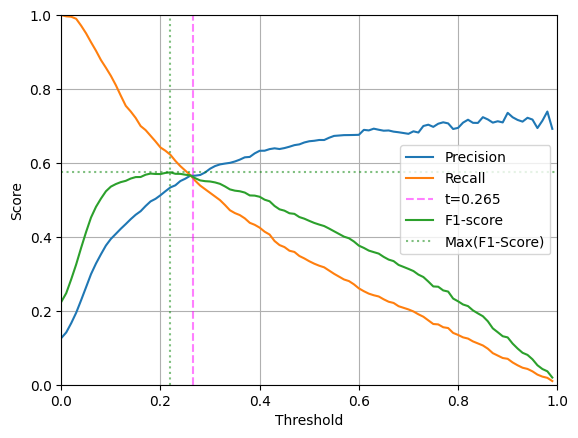

In [18]:
plt.plot(df_scores["threshold"], df_scores["precision"], label="Precision")
plt.plot(df_scores["threshold"], df_scores["recall"], label="Recall")

# Threshold 0.265
plt.vlines(x=0.265, ymin=0, ymax=1, color="magenta", linestyle="--", alpha=0.5, label="t=0.265")

# F1-Score Max
plt.plot(df_scores["threshold"], df_scores["f1-score"], label="F1-score")
f1_max: float = df_scores["f1-score"].max()
t_of_f1_max: float = df_scores["threshold"].loc[df_scores["f1-score"] == f1_max].iloc[0]
plt.hlines(y=f1_max, xmin=0, xmax=1, color="green", linestyle=":", alpha=0.5, label="Max(F1-Score)")
plt.vlines(x=t_of_f1_max, ymin=0, ymax=1, color="green", linestyle=":", alpha=0.5)

plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.grid()
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

#### Answer

`0.22`

In [19]:
df_scores["threshold"].iloc[df_scores["f1-score"].argmax()]

np.float64(0.22)

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

#### Answer

`0.006`

In [20]:
numerical: list[str] = df_train.select_dtypes(include="number").columns.to_list()
categorical: list[str] = df_train.select_dtypes(exclude="number").columns.to_list()
features: list[str] = categorical + numerical

In [21]:
def train(
    df_train: pd.DataFrame,
    target_train: np.ndarray,
    C: float = 1.0,
) -> tuple[DictVectorizer, LogisticRegression]:
    dicts: list[dict] = df_train.to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train: np.ndarray = dv.fit_transform(X=dicts)

    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
    model.fit(X=X_train, y=target_train)

    return dv, model

In [22]:
def predict(df: pd.DataFrame, dv: DictVectorizer, model: LogisticRegression) -> "pd.Series[float]":
    dicts: list[dict] = df.to_dict(orient="records")

    X: np.ndarray = dv.transform(dicts)
    y_pred: "pd.Series[float]" = model.predict_proba(X=X)[:, 1]

    return y_pred

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [24]:
C: float = 1.0
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores: list[float] = []

for train_idx, val_idx in kfold.split(X=df_full_train):
    df_train: pd.DataFrame = df_full_train.iloc[train_idx]
    df_val: pd.DataFrame = df_full_train.iloc[val_idx]

    y_train: np.ndarray = df[target][df_train.index].to_numpy()
    y_val: np.ndarray = df[target][df_val.index].to_numpy()

    dv, model = train(df_train=df_train, target_train=y_train, C=C)
    y_pred: "pd.Series[float]" = predict(df=df_val, dv=dv, model=model)

    auc: float = roc_auc_score(y_true=y_val, y_score=y_pred)
    scores.append(auc)

In [25]:
f"{np.std(scores):.1g}"

'0.006'

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


#### Answer

`1`

In [26]:
stats = {}

for C in [0.000001, 0.001, 1.0]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores: list[float] = []

    for train_idx, val_idx in kfold.split(X=df_full_train):
        df_train: pd.DataFrame = df_full_train.iloc[train_idx]
        df_val: pd.DataFrame = df_full_train.iloc[val_idx]

        y_train: np.ndarray = df[target][df_train.index].to_numpy()
        y_val: np.ndarray = df[target][df_val.index].to_numpy()

        dv, model = train(df_train=df_train, target_train=y_train, C=C)
        y_pred: "pd.Series[float]" = predict(df=df_val, dv=dv, model=model)

        auc: float = roc_auc_score(y_true=y_val, y_score=y_pred)
        scores.append(auc)

    mean_score: float = np.mean(scores)
    std_score: float = np.std(scores)
    stats[C] = {"mean": mean_score, "std": std_score}

    print(f"AUC of C={C}: {mean_score:.2f} +- {std_score:.3f}")

AUC of C=1e-06: 0.70 +- 0.009
AUC of C=0.001: 0.86 +- 0.007
AUC of C=1.0: 0.91 +- 0.006


In [27]:
pd.DataFrame(data=stats).T.sort_values(by="mean", ascending=False)

,mean,std
1.000000,0.905865,0.005653
0.001000,0.860843,0.007180
0.000001,0.701445,0.009444
